In [272]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from fredapi import Fred


# Turn off warnings
warnings.filterwarnings("ignore")

### NIFTY 50 Historica Data
We get latest data from yahoo finance and combine it with older data

In [273]:
# Define ticker and date rangticker = "BSE-500.BO"
start_date = "1980-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

ticker = '^NSEI'
# Download data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data = data[['Close']]
yf_market_data = data['Close'].resample('ME').last()

display(yf_market_data.head())


nifty_historical = pd.read_csv("./data/NIFTY 50_Historical_PRICE.csv")
nifty_historical['Date'] = pd.to_datetime(nifty_historical['Date'])
nifty_historical = nifty_historical.set_index('Date').resample('ME').ffill()
nifty_historical = nifty_historical[:yf_market_data.index[0]-pd.DateOffset(days=15)]

display(nifty_historical.tail())
nifty_historical  = pd.DataFrame(nifty_historical['Close'])
nifty_historical = nifty_historical.rename(columns = {'Close': '^NSEI'})

market_data = pd.concat([nifty_historical, yf_market_data], axis=0)
market_data.iloc[5:]

[*********************100%***********************]  1 of 1 completed


Ticker,^NSEI
Date,
2007-09-30,5021.350098
2007-10-31,5900.649902
2007-11-30,5762.750000
2007-12-31,6138.600098
2008-01-31,5137.450195


,Index Name,Open,High,Low,Close
Date,,,,,
2007-04-30,NIFTY 50,4081.60,4096.90,4028.90,4087.90
2007-05-31,NIFTY 50,4250.25,4306.75,4250.25,4295.80
2007-06-30,NIFTY 50,4282.40,4321.35,4280.95,4318.30
2007-07-31,NIFTY 50,4444.25,4534.20,4432.85,4528.85
2007-08-31,NIFTY 50,4412.60,4471.30,4403.00,4464.00


,^NSEI
Date,
1990-12-31,330.860000
1991-01-31,314.360000
1991-02-28,379.940000
1991-03-31,366.450000
1991-04-30,389.010000
...,...
2025-07-31,24768.349609
2025-08-31,24426.849609
2025-09-30,24611.099609


Plot NIFTY 50 historical cummulative returns

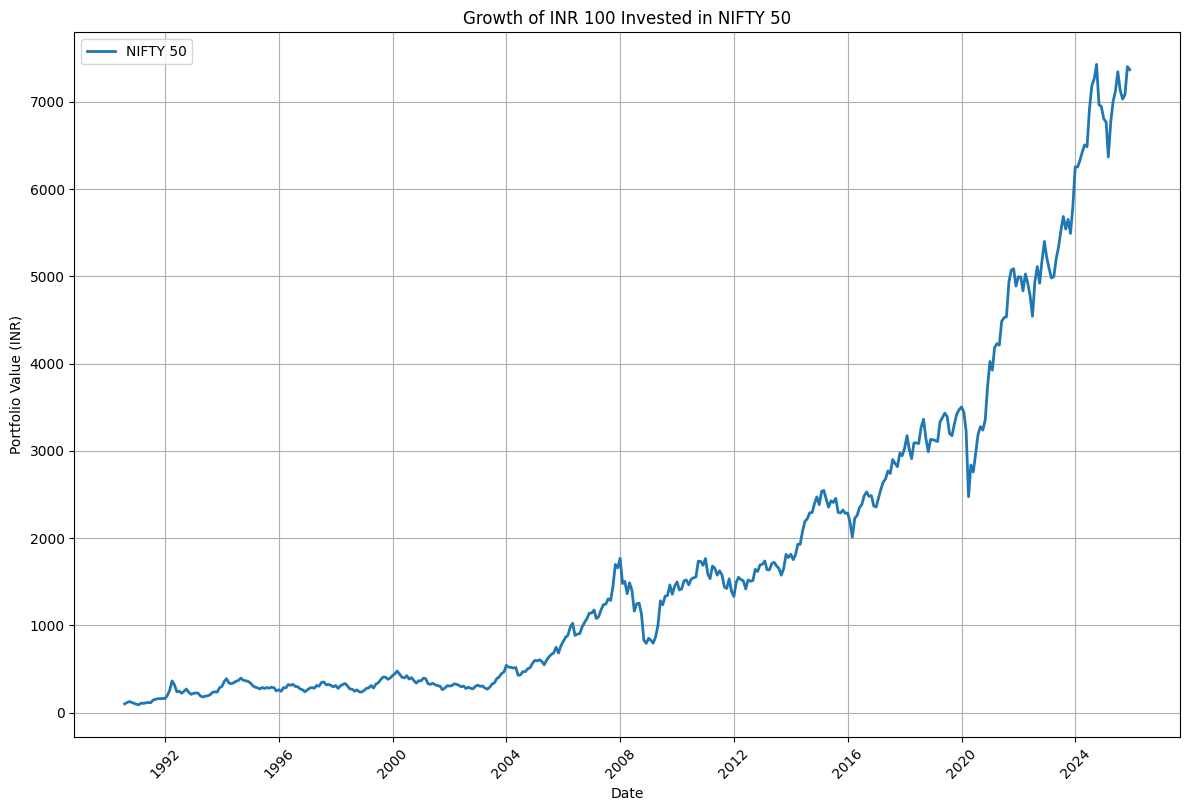

In [274]:
initial_value = 100

market_data['Return'] = market_data['^NSEI'].pct_change()
market_data['Portfolio'] = initial_value * (1 + market_data['Return']).cumprod()
market_data['Portfolio'].iloc[0] = initial_value

# Assuming 'portfolios' dictionary has the portfolios for each factor with 'Date' and 'Portfolio_Value'

# Step 1: Plotting the growth of portfolios for each factor
plt.figure(figsize=(12, 8))

# Plot the portfolio value over time
plt.plot(market_data.index, market_data['Portfolio'], label='NIFTY 50', linewidth = 2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.title('Growth of INR 100 Invested in NIFTY 50')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Create Next Month Return Column

In [275]:
market_data['next_month_return'] = market_data['Return'].shift(-1)
market_data.head()

,^NSEI,Return,Portfolio,next_month_return
Date,,,,
1990-07-31,347.44,NaN,100.000000,0.151451
1990-08-31,400.06,0.151451,115.145061,0.099135
1990-09-30,439.72,0.099135,126.559982,-0.082007
1990-10-31,403.66,-0.082007,116.181211,-0.089110
1990-11-30,367.69,-0.089110,105.828344,-0.100166


### Adding Features (1) - Momentum

In [276]:
features_df_list = []

In [277]:
windows = [1, 3, 6, 9, 12]

market_data['momentum_1_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(1) - 1
market_data['momentum_3_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(3) - 1
market_data['momentum_6_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(6) - 1
market_data['momentum_9_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(9) - 1
market_data['momentum_12_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(12) - 1


market_data.head(13)

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1
Date,,,,,,,,,
1990-07-31,347.44,NaN,100.000000,0.151451,NaN,NaN,NaN,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,0.099135,0.151451,NaN,NaN,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,-0.082007,0.099135,NaN,NaN,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,-0.089110,-0.082007,0.161812,NaN,NaN,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.100166,-0.089110,-0.080913,NaN,NaN,NaN
1990-12-31,330.86,-0.100166,95.227953,-0.049870,-0.100166,-0.247567,NaN,NaN,NaN
1991-01-31,314.36,-0.049870,90.478932,0.208614,-0.049870,-0.221226,-0.095211,NaN,NaN
1991-02-28,379.94,0.208614,109.354133,-0.035506,0.208614,0.033316,-0.050292,NaN,NaN
1991-03-31,366.45,-0.035506,105.471448,0.061564,-0.035506,0.107568,-0.166629,NaN,NaN


### Adding Features (2) - Shiller's CAPE (Cyclically Adjusted P/E)

In [278]:
sheet_id = "1ZcT4v4PzjwACcbzmwYXGwxLMRXtuQGwsSEPyONMcfcU"
sheet_name = "Sheet1"  # or your specific sheet name

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

cape = pd.read_csv(url)
cape['Date'] = pd.to_datetime(cape['Date'])
cape = cape.set_index('Date').resample('ME').last()

features_df_list.append(cape[['BSE Sensex CAPE 5']])
display(cape.head())
# market_data = pd.merge(market_data,cape['BSE Sensex CAPE 5'], left_index=True, right_index=True, how='left')
# market_data.head()

,BSE Sensex CAPE 5,Sensex Close Price,P/E,EPS,Inflation Rate,Inflation Adjusted EPS,Inflation Adjusted Price,Last 120 Month EPS Inflation Adj
Date,,,,,,,,
1995-04-30,35.67,3133.28,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-31,33.25,3351.48,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-30,33.69,3247.36,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-31,32.58,3386.97,NaN,NaN,NaN,NaN,NaN,NaN
1995-08-31,32.55,3346.76,NaN,NaN,NaN,NaN,NaN,NaN


### Adding Features (3) - Inflation

In [279]:
# Step 2: Initialize the FRED API with your API key
# (Get one for free from https://fred.stlouisfed.org/docs/api/api_key.html)
fred = Fred(api_key='8b995803b3d5488cc5f5dcaaedb698ff')

# Step 3: Fetch the data
series_id = 'INDCPIALLMINMEI'
inflation_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
inflation_df = pd.DataFrame(inflation_data, columns=['CPI'])
inflation_df.index.name = 'Date'

# Step 5: Display and plot
print(inflation_df.head())
# inflation_df.plot(title='India CPI (All Items) - INDCPIALLMINMEI')
# plt.show()

inflation_df = inflation_df.resample('ME').last()
inflation_df['inflation_rate'] = inflation_df['CPI'].pct_change()

features_df_list.append(inflation_df[['inflation_rate']])
display(inflation_df.head())
# market_data = pd.merge(market_data,inflation_df[['inflation_rate']], left_index=True, right_index=True, how='left')
# market_data.head()

                 CPI
Date                
1957-01-01  1.471388
1957-02-01  1.471388
1957-03-01  1.471388
1957-04-01  1.500524
1957-05-01  1.511450


,CPI,inflation_rate
Date,,
1957-01-31,1.471388,NaN
1957-02-28,1.471388,0.000000
1957-03-31,1.471388,0.000000
1957-04-30,1.500524,0.019802
1957-05-31,1.511450,0.007281


### Adding Features (4) - Interest Rates

In [280]:
# Step 3: Fetch the data
series_id = 'IRSTCI01INM156N'
interest_rate_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
interest_rate_df = pd.DataFrame(interest_rate_data, columns=['Interest_Rate'])
interest_rate_df.index.name = 'Date'

# Step 5: Display and plot
print(interest_rate_df.head())
# inflation_df.plot(title='India CPI (All Items) - INDCPIALLMINMEI')
# plt.show()

interest_rate_df = interest_rate_df.resample('ME').last()

features_df_list.append(interest_rate_df)
display(interest_rate_df.head())
# market_data = pd.merge(market_data,interest_rate_df, left_index=True, right_index=True, how='left')
# market_data.head()

            Interest_Rate
Date                     
1968-01-01            6.0
1968-02-01            6.0
1968-03-01            5.0
1968-04-01            5.0
1968-05-01            5.0


,Interest_Rate
Date,
1968-01-31,6.0
1968-02-29,6.0
1968-03-31,5.0
1968-04-30,5.0
1968-05-31,5.0


### Adding Features (5) - USD / INR Exchange Rate

In [281]:
series_id = 'DEXINUS'
usd_inr_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
usd_inr_data_df = pd.DataFrame(usd_inr_data, columns=['USDINR=X'])
usd_inr_data_df.index.name = 'Date'
usd_inr_data_df = usd_inr_data_df.resample('ME').last()


ticker = 'USDINR=X'
# Download data
start_date = usd_inr_data_df.index[-1] + MonthEnd(1)
usd_inr = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
usd_inr = usd_inr[['Close']]
usd_inr = usd_inr.resample('ME').last()

usd_inr = pd.concat([usd_inr_data_df,usd_inr['Close']], axis=0)
usd_inr.head()

features_df_list.append(usd_inr)
display(usd_inr.head())
# market_data = pd.merge(market_data,usd_inr, left_index=True, right_index=True, how='left')
# market_data.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['USDINR=X']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-11-30 00:00:00 -> 2025-11-06) (Yahoo error = "Invalid input - start date cannot be after end date. startDate = 1764460800, endDate = 1762387200")')


,USDINR=X
Date,
1973-01-31,8.00
1973-02-28,7.52
1973-03-31,7.55
1973-04-30,7.53
1973-05-31,7.39


### Adding Features (6) - Global Equity - MSCI World

In [282]:
ticker = '^990100-USD-STRD'
# Download data
start_date = market_data.index[0]
world_equity = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
world_equity = pd.DataFrame(world_equity['Close'])
world_equity.rename(columns = {'^990100-USD-STRD': 'World_Equity'}, inplace=True)
world_equity = world_equity.resample('ME').last()

display(world_equity.head())

features_df_list.append(world_equity)
display(world_equity.head())
# market_data = pd.merge(market_data,world_equity, left_index=True, right_index=True, how='left')
# market_data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,World_Equity
Date,
1990-07-31,524.200012
1990-08-31,474.100006
1990-09-30,423.100006
1990-10-31,461.600006
1990-11-30,453.100006


Ticker,World_Equity
Date,
1990-07-31,524.200012
1990-08-31,474.100006
1990-09-30,423.100006
1990-10-31,461.600006
1990-11-30,453.100006


### Adding Features (7) - Leading Composite Index

In [283]:
import requests
import pandas as pd
from io import StringIO

# Define API query URL (example for CSV with labels format)
# This URL is an example and would need to be adapted based on your specific data selection in the OECD Data Explorer.
url = "https://sdmx.oecd.org/public/rest/data/OECD.SDD.STES,DSD_STES@DF_CLI,/IND.M.LI...AA...H?dimensionAtObservation=AllDimensions&format=csvfilewithlabels"

# Fetch data
response = requests.get(url)
response.raise_for_status() # Raise an exception for bad status codes

# print(response.text)  # Print the first 500 characters of the response for inspection

# Read the CSV data into a pandas DataFrame
leading_composite_index_df = pd.read_csv(StringIO(response.text))
leading_composite_index_df = leading_composite_index_df[['TIME_PERIOD','OBS_VALUE']].set_index('TIME_PERIOD')
leading_composite_index_df.index = pd.to_datetime(leading_composite_index_df.index)
leading_composite_index_df = leading_composite_index_df.resample('ME').last()

# Display the first few rows of the DataFrame
display(leading_composite_index_df.head())

features_df_list.append(leading_composite_index_df)
# market_data = pd.merge(market_data,leading_composite_index_df, left_index=True, right_index=True, how='left')
# market_data.tail()

,OBS_VALUE
TIME_PERIOD,
1994-04-30,98.80656
1994-05-31,99.27505
1994-06-30,99.70493
1994-07-31,100.09120
1994-08-31,100.43150


### Adding Features (8) - Debt to GDP

In [284]:
series_id = 'NGDPRNSAXDCINQ'
gdp_data = fred.get_series(series_id)

# Step 4: Convert to DataFrame for easier handling
gdp_data_df = pd.DataFrame(gdp_data, columns=['GDP'])
gdp_data_df.index.name = 'Date'
gdp_data_df = gdp_data_df.resample('ME').last().ffill()

features_df_list.append(gdp_data_df)
display(gdp_data_df.head())

,GDP
Date,
2004-04-30,11733591.9
2004-05-31,11733591.9
2004-06-30,11733591.9
2004-07-31,11859353.6
2004-08-31,11859353.6


In [285]:
for feature_df in features_df_list:
    market_data = pd.merge(market_data, feature_df, left_index=True, right_index=True, how='left')

market_data.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,inflation_rate,Interest_Rate,USDINR=X,World_Equity,OBS_VALUE,GDP
Date,,,,,,,,,,,,,,,,
1990-07-31,347.44,NaN,100.000000,0.151451,NaN,NaN,NaN,NaN,NaN,NaN,0.021621,10.0,17.35,524.200012,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,0.099135,0.151451,NaN,NaN,NaN,NaN,NaN,0.005291,10.0,17.52,474.100006,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,-0.082007,0.099135,NaN,NaN,NaN,NaN,NaN,0.005263,10.0,18.00,423.100006,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,-0.089110,-0.082007,0.161812,NaN,NaN,NaN,NaN,0.020942,10.0,18.16,461.600006,NaN,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.100166,-0.089110,-0.080913,NaN,NaN,NaN,NaN,0.015385,10.0,18.17,453.100006,NaN,NaN


In [332]:
market_data['USDINR=X'] = market_data['USDINR=X'].pct_change()
market_data['World_Equity'] = market_data['World_Equity'].pct_change()
market_data['BSE Sensex CAPE 5'] = market_data['BSE Sensex CAPE 5'].pct_change()
market_data['GDP'] = market_data['^NSEI']/market_data['GDP']

In [352]:
feature_columns = [
       'momentum_1_1', 'momentum_6_1', 'BSE Sensex CAPE 5', 'inflation_rate',
       'Interest_Rate', 'OBS_VALUE', 'USDINR=X', 'World_Equity']

market_data_clean = market_data[feature_columns + ['next_month_return']].dropna()
market_data_clean

,momentum_1_1,momentum_6_1,BSE Sensex CAPE 5,inflation_rate,Interest_Rate,OBS_VALUE,USDINR=X,World_Equity,next_month_return
Date,,,,,,,,,
1995-05-31,0.059002,-0.199326,-0.067844,0.016949,12.00,102.10420,-1.666596,-65.687113,-0.036264
1995-06-30,-0.036264,-0.186914,0.013233,0.020000,12.00,102.20960,-1.000318,1.164673,0.034352
1995-07-31,0.034352,-0.071835,-0.032947,0.022876,12.00,102.29620,-3145.000637,3.984107,-0.022640
1995-08-31,-0.022640,-0.042338,-0.000921,0.006390,12.00,102.35870,-11.489661,-0.822925,0.041328
1995-09-30,0.041328,0.021873,-0.022734,0.006349,12.00,102.39440,-0.826570,0.250085,-0.023362
...,...,...,...,...,...,...,...,...,...
2024-11-30,-0.003068,0.071032,-0.035725,0.000000,6.75,99.97632,-1.074680,0.445922,-0.020152
2024-12-31,-0.020152,-0.015235,0.009500,-0.005536,6.75,100.01640,2.885923,-0.498550,-0.005769
2025-01-31,-0.005769,-0.057823,-0.051443,-0.003480,6.75,100.06400,-1.056248,0.432933,-0.058860


In [353]:
# Create the 'positive_returns' column
bins = [-np.inf,-0.02, np.inf]
labels = [0, 1]
market_data_clean['regime'] = pd.cut(
    market_data_clean['next_month_return'],
    bins=bins,
    labels=labels
).astype(int)

In [354]:
market_data_clean['regime']

Date
1995-05-31    0
1995-06-30    1
1995-07-31    0
1995-08-31    1
1995-09-30    0
             ..
2024-11-30    0
2024-12-31    1
2025-01-31    0
2025-02-28    1
2025-03-31    1
Freq: ME, Name: regime, Length: 359, dtype: int64

## Pre Processing

ValueError: Could not interpret value `momentum_12_1` for `x`. An entry with this name does not appear in `data`.

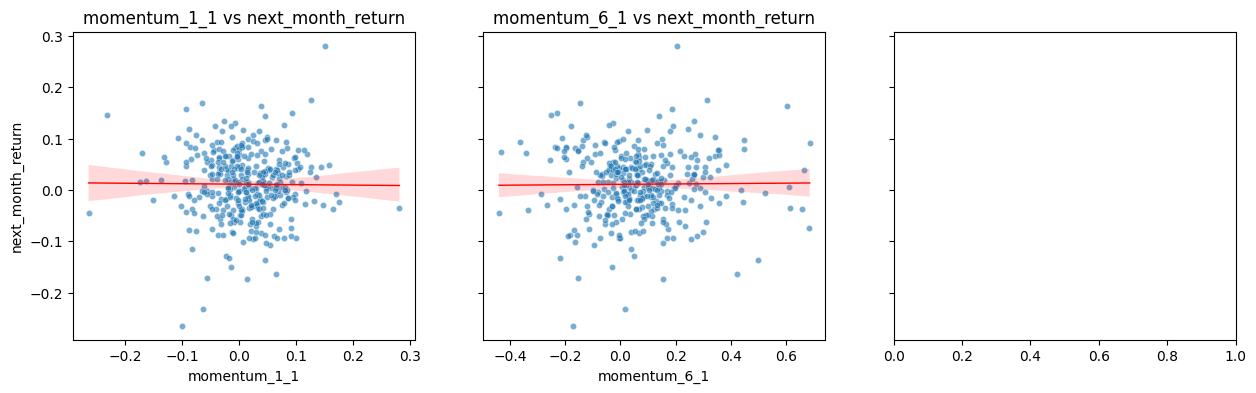

In [312]:
mom_feats = ['momentum_1_1', 'momentum_6_1', 'momentum_12_1']
df = market_data_clean.copy()

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(mom_feats), figsize=(5 * len(mom_feats), 4), sharey=True)
for ax, feat in zip(axes, mom_feats):
    sns.scatterplot(x=feat, y='next_month_return', data=df, ax=ax, s=20, alpha=0.6)
    sns.regplot(x=feat, y='next_month_return', data=df, ax=ax, scatter=False, color='red', line_kws={'linewidth':1})
    ax.set_xlabel(feat)
    if ax is axes[0]:
        ax.set_ylabel('next_month_return')
    ax.set_title(f'{feat} vs next_month_return')

plt.tight_layout()
plt.show()

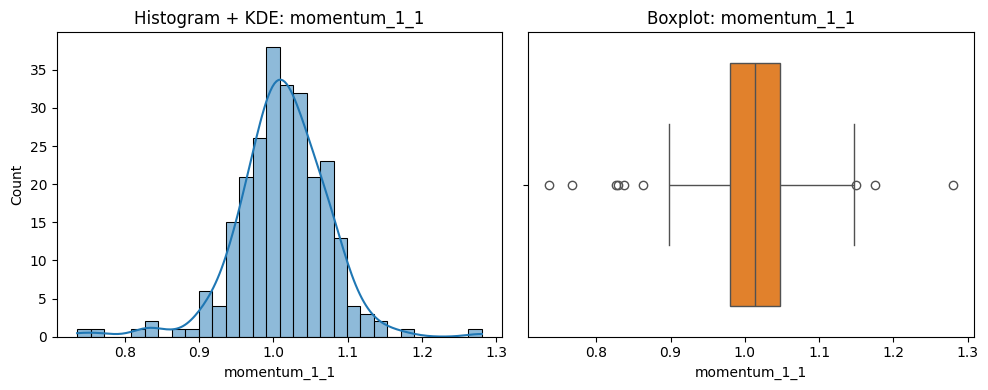

In [ ]:
col = 'momentum_1_1'
data = market_data_clean[col]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))

# Histogram with KDE
plt.subplot(1,2,1)
sns.histplot(data, bins=30, kde=True, color='C0')
plt.title(f'Histogram + KDE: {col}')
plt.xlabel(col)
plt.ylabel('Count')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=data, color='C1')
plt.title(f'Boxplot: {col}')
plt.xlabel(col)

plt.tight_layout()
plt.show()

In [355]:
# Create regimes for each feature
for col in feature_columns:
    # Calculate percentiles
    percentile_33 = market_data_clean[col].quantile(0.33)
    percentile_66 = market_data_clean[col].quantile(0.66)
    
    # Create bins using percentiles
    bins = [-np.inf, percentile_33, percentile_66, np.inf]
    labels = [0, 1, 2]  # 0: Bear/Low, 1: Neutral/Medium, 2: Bull/High
    
    # Create regime column
    market_data_clean[col + '_regime'] = pd.cut(
        market_data_clean[col],
        bins=bins,
        labels=labels
    ).astype(int)
    
    # Print the bin edges
    print(f"\nRegime boundaries for {col}:")
    print(f"Low regime: < {percentile_33:.3f}")
    print(f"Medium regime: {percentile_33:.3f} to {percentile_66:.3f}")
    print(f"High regime: >= {percentile_66:.3f}")


Regime boundaries for momentum_1_1:
Low regime: < -0.013
Medium regime: -0.013 to 0.038
High regime: >= 0.038

Regime boundaries for momentum_6_1:
Low regime: < -0.008
Medium regime: -0.008 to 0.113
High regime: >= 0.113

Regime boundaries for BSE Sensex CAPE 5:
Low regime: < -0.015
Medium regime: -0.015 to 0.023
High regime: >= 0.023

Regime boundaries for inflation_rate:
Low regime: < 0.002
Medium regime: 0.002 to 0.008
High regime: >= 0.008

Regime boundaries for Interest_Rate:
Low regime: < 6.000
Medium regime: 6.000 to 7.000
High regime: >= 7.000

Regime boundaries for OBS_VALUE:
Low regime: < 99.458
Medium regime: 99.458 to 100.471
High regime: >= 100.471


ValueError: Cannot convert float NaN to integer

In [337]:
feature_columns_regime = [col + '_regime' for col in feature_columns]
market_data_clean[feature_columns_regime + ['regime']]

,momentum_1_1_regime,momentum_6_1_regime,BSE Sensex CAPE 5_regime,inflation_rate_regime,Interest_Rate_regime,OBS_VALUE_regime,regime
Date,,,,,,,
1995-05-31,2,0,0,2,2,2,0
1995-06-30,0,0,1,2,2,2,1
1995-07-31,1,0,0,2,2,2,0
1995-08-31,0,0,1,1,2,2,1
1995-09-30,2,1,0,1,2,2,0
...,...,...,...,...,...,...,...
2024-11-30,1,1,0,0,1,1,0
2024-12-31,0,0,1,0,1,1,1
2025-01-31,1,0,0,0,1,1,0


In [356]:
for col in feature_columns:
    mean = market_data_clean[col].mean()
    std = market_data_clean[col].std()
    if std == 0 or np.isnan(std):
        market_data_clean[f"{col}_zscore"] = 0.0
    else:
        market_data_clean[f"{col}_zscore"] = (market_data_clean[col] - mean) / std

In [357]:
z_score_columns = [f"{col}_zscore" for col in feature_columns]
z_score_columns

['momentum_1_1_zscore',
 'momentum_6_1_zscore',
 'BSE Sensex CAPE 5_zscore',
 'inflation_rate_zscore',
 'Interest_Rate_zscore',
 'OBS_VALUE_zscore',
 'USDINR=X_zscore',
 'World_Equity_zscore']

## Random Forest Classifier

In [365]:
from itertools import combinations

# assume z_score_columns already exists
feature_pairs = list(combinations(z_score_columns, 1))            # list of tuples

split_of_date_to_use = round(0.8*len(market_data_clean))
# Features and target variable
for feature_pair in feature_pairs:
       print(feature_pair)
       X = market_data_clean[list(feature_pair)].iloc[:split_of_date_to_use]
       y = market_data_clean['regime'].iloc[:split_of_date_to_use]

       # Initialize the Random Forest Classifier
       clf = RandomForestClassifier(n_estimators=10, random_state=42)

       # Define k-fold cross-validation (-fold)
       kfold = StratifiedKFold(n_splits=10, shuffle=False)

       # Perform cross-validation
       cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

       # Train the model
       clf.fit(X, y)

       # Output results
       print(f"Cross-Validation Scores: {cv_scores}")
       print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
       print(f"Standard Deviation: {np.std(cv_scores):.4f}")

('momentum_1_1_zscore',)
Cross-Validation Scores: [0.62068966 0.5862069  0.65517241 0.75862069 0.5862069  0.65517241
 0.48275862 0.78571429 0.60714286 0.46428571]
Mean Accuracy: 0.6202
Standard Deviation: 0.0973
('momentum_6_1_zscore',)
Cross-Validation Scores: [0.5862069  0.5862069  0.51724138 0.55172414 0.51724138 0.44827586
 0.37931034 0.71428571 0.75       0.42857143]
Mean Accuracy: 0.5479
Standard Deviation: 0.1122
('BSE Sensex CAPE 5_zscore',)
Cross-Validation Scores: [0.5862069  0.62068966 0.48275862 0.62068966 0.68965517 0.62068966
 0.51724138 0.57142857 0.46428571 0.46428571]
Mean Accuracy: 0.5638
Standard Deviation: 0.0739
('inflation_rate_zscore',)
Cross-Validation Scores: [0.68965517 0.48275862 0.55172414 0.65517241 0.5862069  0.65517241
 0.48275862 0.53571429 0.57142857 0.60714286]
Mean Accuracy: 0.5818
Standard Deviation: 0.0677
('Interest_Rate_zscore',)
Cross-Validation Scores: [0.37931034 0.27586207 0.68965517 0.72413793 0.72413793 0.72413793
 0.68965517 0.53571429 0.32

In [381]:
pair_1 = ['momentum_1_1_zscore',
 'momentum_6_1_zscore']

pair_2 = ['BSE Sensex CAPE 5_zscore']
pair_3 = ['inflation_rate_zscore']
pair_4 = ['World_Equity_zscore']
pair_5 = ['USDINR=X_zscore']

feature_pairs = [pair_1, pair_2, pair_3, pair_4, pair_5]

split_of_date_to_use = round(0.8*len(market_data_clean))
for feature_pair in feature_pairs:
       print(feature_pair)
       X = market_data_clean[list(feature_pair)].iloc[:split_of_date_to_use]
       y = market_data_clean['regime'].iloc[:split_of_date_to_use]

       # Initialize the Random Forest Classifier
       clf = RandomForestClassifier(n_estimators=10, random_state=42)

       # Define k-fold cross-validation (-fold)
       kfold = StratifiedKFold(n_splits=10, shuffle=False)

       # Perform cross-validation
       cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

       # Train the model
       clf.fit(X, y)

       # Output results
       print(f"Cross-Validation Scores: {cv_scores}")
       print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
       print(f"Standard Deviation: {np.std(cv_scores):.4f}")



['momentum_1_1_zscore', 'momentum_6_1_zscore']
Cross-Validation Scores: [0.68965517 0.68965517 0.62068966 0.62068966 0.5862069  0.62068966
 0.48275862 0.5        0.57142857 0.60714286]
Mean Accuracy: 0.5989
Standard Deviation: 0.0649
['BSE Sensex CAPE 5_zscore']
Cross-Validation Scores: [0.5862069  0.62068966 0.48275862 0.62068966 0.68965517 0.62068966
 0.51724138 0.57142857 0.46428571 0.46428571]
Mean Accuracy: 0.5638
Standard Deviation: 0.0739
['inflation_rate_zscore']
Cross-Validation Scores: [0.68965517 0.48275862 0.55172414 0.65517241 0.5862069  0.65517241
 0.48275862 0.53571429 0.57142857 0.60714286]
Mean Accuracy: 0.5818
Standard Deviation: 0.0677
['World_Equity_zscore']
Cross-Validation Scores: [0.48275862 0.65517241 0.51724138 0.62068966 0.68965517 0.5862069
 0.5862069  0.71428571 0.53571429 0.75      ]
Mean Accuracy: 0.6138
Standard Deviation: 0.0838
['USDINR=X_zscore']
Cross-Validation Scores: [0.68965517 0.68965517 0.68965517 0.72413793 0.72413793 0.72413793
 0.72413793 0.7

In [385]:
from sklearn.metrics import accuracy_score

i = 0
test_data_final = market_data_clean.iloc[split_of_date_to_use:]
for feature_pair in feature_pairs:
    X = market_data_clean[list(feature_pair)].iloc[:split_of_date_to_use]
    y = market_data_clean['regime'].iloc[:split_of_date_to_use]

    # Initialize the Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=10, random_state=42)
    clf.fit(X, y)

    test_data_final['regime' + '_' + str(i)] = clf.predict(test_data_final[feature_pair])
    i+=1



In [386]:
test_data_final['regime_prediction'] = test_data_final[[ 'regime_0', 'regime_1', 'regime_2', 'regime_3', 'regime_4']].mode(axis=1)[0]
test_data_final[['regime', 'regime_prediction']]

,regime,regime_prediction
Date,,
2019-04-30,1,1
2019-05-31,1,1
2019-06-30,0,1
2019-07-31,1,1
2019-08-31,1,1
...,...,...
2024-11-30,0,1
2024-12-31,1,1
2025-01-31,0,1


In [387]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_data_final["regime"], test_data_final["regime_prediction"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

acc_score = accuracy_score(test_data_final["regime"], test_data_final["regime_prediction"])
print(f"Accuracy: {acc_score*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            1           18
Actual 1            2           51
Accuracy: 72.22%
